# Download and extract dataset

As an initial step, it is of essential importance to download the [Public Coin Dataset](https://drive.google.com/file/d/1cF-u9N7miok5-KUiriTdvA62edxIs1I_) and extract its contents. Moreover, we retrieve the parameters from the previously executed training sessions, which will be instrumental in our ongoing work.


In [1]:
!gdown 1cF-u9N7miok5-KUiriTdvA62edxIs1I_ -O public_coin_dataset.zip
!gdown 1RaRbCZHKc8kIeI6KaznPxO_9VM3tE6TP -O model_checkpoints_pretrained.pth
!unzip -qq -o public_coin_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1cF-u9N7miok5-KUiriTdvA62edxIs1I_
To: /content/public_coin_dataset.zip
100% 40.6M/40.6M [00:00<00:00, 299MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RaRbCZHKc8kIeI6KaznPxO_9VM3tE6TP
To: /content/model_checkpoints_pretrained.pth
100% 62.2M/62.2M [00:01<00:00, 57.1MB/s]


# Importing
Importing all the libraries utilized in the tasks


In [2]:
import cv2
import os
import random
import torch

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from torch import nn
from torch.nn.functional import pad
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor, CenterCrop, RandomRotation, ColorJitter
from torchvision.transforms.functional import hflip, vflip, rotate, center_crop
from torchvision.transforms.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip

## Model
I decided to employ the [U-net](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/) neural network architecture for the specific segmentation task, known for its effectiveness in image segmentation and feature extraction. \\

This U-Net model consists of a multi-level structure with four levels of blocks. Each block includes a pair of convolutional layers with batch normalization and ReLU activation functions. There is one additional max-pooling layer in the encoding part, while in the decoding part, up-convolutional layers are utilized instead.

In [3]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, pretrained=False)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


In [4]:
class CoinDataset(Dataset):
  def __init__(self, image_list: list, patch_size: int, transform=None):
    super(Dataset, self).__init__()
    self.transform = transform
    self.patch_size = patch_size
    self.path_images = image_list

  def __len__(self) -> int:
    return len(self.path_images)

  def __getitem__(self, index):
    original_path = os.path.join(self.path_images[index], "original", "coin.jpeg")
    no_background_path = os.path.join(self.path_images[index], "no_bg", "coin.jpeg")

    original_image = Image.open(original_path).convert("RGB")
    no_background_image = Image.open(no_background_path).convert("L")
    no_background_image = np.asarray(no_background_image)
    no_background_image = (no_background_image != 0) * 1.0
    no_background_image = Image.fromarray(no_background_image)

    if self.transform:
      original_image, no_background_image = self.transform((original_image, no_background_image))

    pad_width = self.patch_size - original_image.size(2)
    pad_height = self.patch_size - original_image.size(1)

    padding = (pad_width, pad_height, pad_width, pad_height)
    original_image = pad(original_image, padding, 'replicate')
    no_background_image = pad(no_background_image, padding)
    original_image = center_crop(original_image, output_size=self.patch_size)
    no_background_image = center_crop(no_background_image, output_size=self.patch_size)

    return original_image, no_background_image

### Augmentation
In light of the dataset's lack of images, a deliberate strategy was employed to incorporate augmentation methods. This strategic decision was motivated by the need to mitigate issues related to overfitting and underfitting. \\

To ensure uniform application of the desired alterations to input images and their corresponding ground truths, a sophisticated approach was adopted involving customising Transform modules within the PyTorch library.

In [5]:
class RandomHorizontalFlip(RandomHorizontalFlip):

  def __call__(self, samples):
    image, gt = samples
    if random.random() < self.p:
      image = hflip(image)
      gt = hflip(gt)
    return image, gt

class RandomVerticalFlip(RandomVerticalFlip):

  def __call__(self, samples):
    image, gt = samples
    if random.random() < self.p:
      image = vflip(image)
      gt = vflip(gt)
    return image, gt

class ToTensor(ToTensor):

  def __call__(self, samples):
    image, gt = samples
    image = super().__call__(image)
    gt = super().__call__(gt)
    return image, gt

In [6]:
# Reproducibility
seed_value = 11
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Configure
transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
])

# Load paths
root_dir = "public_coin_dataset"
paths = [os.path.join(root_dir, path) for path in os.listdir(root_dir)]
random.shuffle(paths)
split_index = int(len(paths) * 70 / 100)
train_paths = paths[:split_index]
test_paths = paths[split_index:]

training_batch_size = 16
dev_batch_size = 4
training_data = CoinDataset(image_list = train_paths, patch_size = 384, transform=transform)
train_dataloader = DataLoader(training_data, batch_size=training_batch_size, shuffle=True)
test_data = CoinDataset(test_paths, patch_size=384, transform=ToTensor())
test_dataloader = DataLoader(test_data, batch_size=dev_batch_size, shuffle=False)

device = "cpu"
if torch.cuda.is_available():
    model = model.to('cuda')
    torch.cuda.manual_seed(seed_value)
    device = "cuda"

## Training

The dataset was methodically split into two segments, with a distribution ratio of 70% for training data and 30% for testing data. This division was meticulously designed to facilitate effective model training and comprehensive testing. \\

In the context of this project, the choice of loss function fell upon MSE (Mean Squared Error) due to its suitability for the task. Additionally, RMSProp was selected as the optimizer to fine-tune the model's performance."

In [7]:
# Train
import sys
epochs = 30
best_accuracy = 0.0
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# Load pre-trained if available
if os.path.exists("model_checkpoints.pth"):
  checkpoint = torch.load("model_checkpoints.pth")
  model.load_state_dict(checkpoint["checkpoints"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  best_accuracy = checkpoint["best_accuracy"]
  print("Loaded Pre-trained")

for epoch in range(epochs):
  training_loss, dev_loss, accuracy = 0., 0., 0.

  model.train(True)
  for (inputs, targets) in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    predictions = model(inputs)
    loss = loss_fn(predictions, targets)

    loss.backward()
    optimizer.step()
    training_loss += loss.item() * inputs.size(0)

  model.eval()
  with torch.no_grad():
    for (inputs, targets) in test_dataloader:
      inputs, targets = inputs.to(device), targets.to(device)
      predictions = model(inputs)
      dev_loss += loss_fn(predictions, targets).item() * inputs.size(0)
      acc = (torch.round(predictions) == targets).float().mean()
      accuracy += acc

  avg_accuracy = accuracy / len(test_dataloader) * 100
  avg_training_loss = training_loss / len(train_dataloader.sampler)
  avg_dev_loss = dev_loss / len(test_dataloader.sampler)

  if best_accuracy < avg_accuracy:
    best_accuracy = avg_accuracy
    torch.save({
        'checkpoints': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_accuracy': best_accuracy
        }, "model_checkpoints.pth")

  print(f"EPOCH [{epoch + 1}/{epochs}] TRAIN LOSS: {avg_training_loss:>7f}, DEV LOSS: {avg_dev_loss:>7f}, Accuracy: {avg_accuracy:.2f}%, Best Accuracy: {best_accuracy:.2f}%")

EPOCH [1/30] TRAIN LOSS: 0.171590, DEV LOSS: 0.676315, Accuracy: 29.37%, Best Accuracy: 29.37%
EPOCH [2/30] TRAIN LOSS: 0.106028, DEV LOSS: 0.198863, Accuracy: 71.12%, Best Accuracy: 71.12%
EPOCH [3/30] TRAIN LOSS: 0.066513, DEV LOSS: 0.186912, Accuracy: 71.37%, Best Accuracy: 71.37%
EPOCH [4/30] TRAIN LOSS: 0.069315, DEV LOSS: 0.167618, Accuracy: 72.21%, Best Accuracy: 72.21%
EPOCH [5/30] TRAIN LOSS: 0.057218, DEV LOSS: 0.180603, Accuracy: 73.94%, Best Accuracy: 73.94%
EPOCH [6/30] TRAIN LOSS: 0.065807, DEV LOSS: 0.149859, Accuracy: 76.83%, Best Accuracy: 76.83%
EPOCH [7/30] TRAIN LOSS: 0.055165, DEV LOSS: 0.043697, Accuracy: 96.20%, Best Accuracy: 96.20%
EPOCH [8/30] TRAIN LOSS: 0.060306, DEV LOSS: 0.095861, Accuracy: 88.07%, Best Accuracy: 96.20%
EPOCH [9/30] TRAIN LOSS: 0.056748, DEV LOSS: 0.038036, Accuracy: 95.86%, Best Accuracy: 96.20%
EPOCH [10/30] TRAIN LOSS: 0.051813, DEV LOSS: 0.486268, Accuracy: 41.97%, Best Accuracy: 96.20%
EPOCH [11/30] TRAIN LOSS: 0.057579, DEV LOSS: 0.1

## Show Results

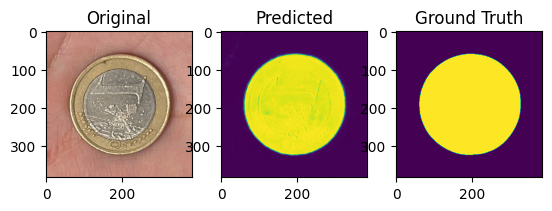

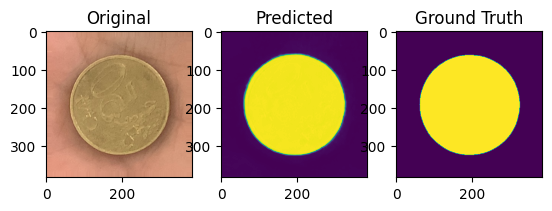

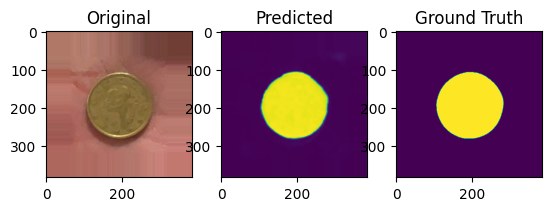

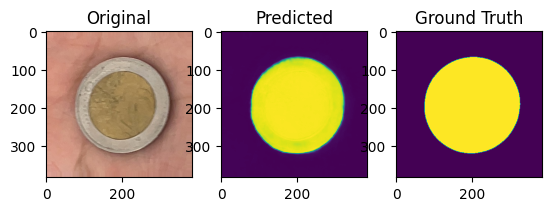

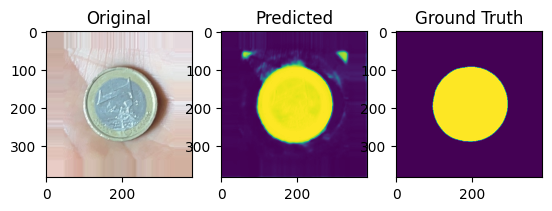

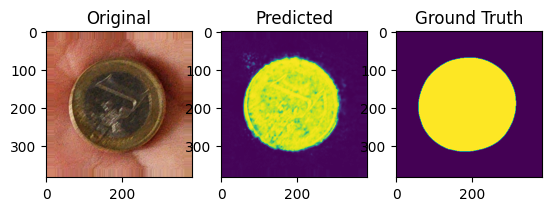

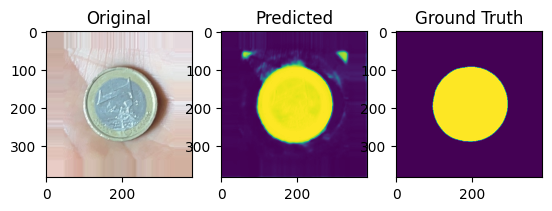

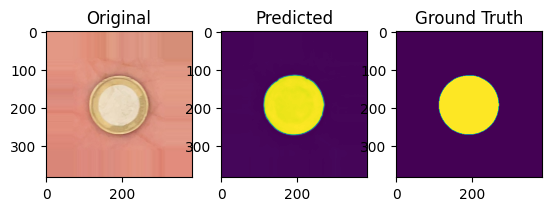

In [8]:
# Show Results
dataloader = DataLoader(
    CoinDataset(random.choices(test_paths, k = 8), patch_size=384, transform=ToTensor()),
    batch_size=1,
    shuffle=False
)
accuracy = 0.
if os.path.exists("model_checkpoints_pretrained.pth"):
  checkpoint = torch.load("model_checkpoints_pretrained.pth")
  model.load_state_dict(checkpoint["checkpoints"])
model.eval()

with torch.no_grad():
  for i, (inputs, targets) in enumerate(dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = model(inputs)

    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(inputs[0].cpu().swapaxes(0, 2))
    ax[0].set_title("Original")
    ax[1].imshow(predictions[0].cpu().swapaxes(0, 2))
    ax[1].set_title("Predicted")
    ax[2].imshow(targets[0].cpu().swapaxes(0, 2))
    ax[2].set_title("Ground Truth")
    plt.show()

# Hough Transform

An alternative approach was explored during the experimentation phase, which diverged from deep learning methodologies and instead leveraged the OpenCV Hough Transform function for circle detection.

Although this approach resulted in a slightly lower accuracy, it demonstrated a notable advantage in terms of execution speed, making it a pragmatic choice for specific scenarios.

In [9]:
root_dir = "public_coin_dataset"
path_images = [os.path.join(root_dir, path) for path in os.listdir(root_dir)]
random.shuffle(path_images)

accuracy = 0.0
not_detected = 0

for image_path in path_images:
  original_path = os.path.join(image_path, "original", "coin.jpeg")
  no_background_path = os.path.join(image_path, "no_bg", "coin.jpeg")

  original_image = cv2.imread(original_path, cv2.IMREAD_COLOR)
  no_background = cv2.imread(no_background_path, cv2.IMREAD_GRAYSCALE)

  try:
    # Elaborate circle
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)
    rows = blurred_image.shape[0]
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, 1.5, rows / 2, 50, 30)

    big_circle = circles[0][0]
    center = (int(np.floor(big_circle[0])), int(np.floor(big_circle[1])))
    radius = int(np.floor(big_circle[2]))
    result_image = original_image.copy()
    cv2.circle(result_image, center, radius, (255, 255, 255), thickness=cv2.FILLED)

    bin_result = ((result_image == (255, 255, 255)) * (255, 255, 255))[:, :, 0]
    bin_background = (no_background != 0) * 255

    accuracy += (bin_result == bin_background).mean()

  except Exception:
    not_detected += 1
    continue

avg_accuracy = accuracy / len(path_images) * 100
print(f"Accuracy: {avg_accuracy:.2f}%")
print(f"Number of not detected image: {not_detected}")

Accuracy: 88.20%
Number of not detected image: 1


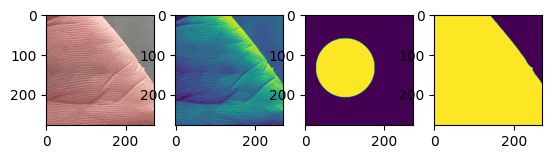

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(blurred_image)
ax[2].imshow(bin_result)
ax[3].imshow(bin_background)
plt.show()

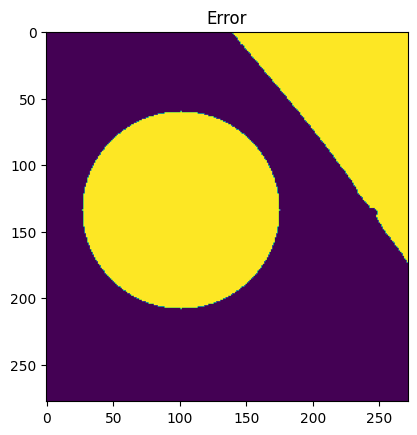

In [11]:
plt.imshow(bin_result - bin_background)
plt.title("Error")
plt.show()